In [ ]:
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import io, os
import sagemaker
import sys
!{sys.executable} -m pip install PyAthena
from pyathena import connect
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer
from sagemaker.image_uris import retrieve
from sagemaker.session import TrainingInput
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Get data type to train model

In [2]:
#data_type = 'genomic'
#data_type = 'genomic-clinical'
data_type = 'genomic-clinical-imaging'

## Set up S3 buckets and session

In [3]:
sm_session = sagemaker.Session()
bucket = sm_session.default_bucket()
region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

role = get_execution_role()
s3_client = boto3.client('s3', region_name=region)

default_s3_bucket_name = feature_store_session.default_bucket()
prefix = 'sagemaker-featurestore-demo'

## Get features from SageMaker FeatureStore based on data type

In [4]:
conn = connect(s3_staging_dir='s3://'+bucket, region_name=region)

# Replace table names 
genomic_table = 'sagemaker_featurestore."genomic-feature-group-26-22-28-08-1616797688"'
clinical_table = 'sagemaker_featurestore."clinical-feature-group-26-22-28-52-1616797732"'
imaging_table = 'sagemaker_featurestore."nsclc-radiogenomics-imaging-feature-group-03-19-2021-1616208039"'


def get_features(data_type):
    
    if (data_type == 'genomic'):
        query_string = 'SELECT * FROM '+genomic_table
        data_gen = pd.read_sql(query_string, conn)
 
        # Drop features
        l_drop = ['case_id', 'pathologicalmstage', 'eventtime', 'write_time', 'api_invocation_time', 'is_deleted'] 
        dataset = data_gen.drop(l_drop,axis = 1)
        
        return dataset
    
        
    elif (data_type == 'genomic-clinical'):
        query_string = 'SELECT * FROM '+clinical_table+' \
        LEFT JOIN '+genomic_table+' ON '+clinical_table+'.case_id = '+genomic_table+'.case_id'
        data_genclin = pd.read_sql(query_string, conn)
        
        # Drop features
        l_drop = ['case_id', 'survival_status', 'pathologicalmstage', 'eventtime', 'write_time', 'api_invocation_time', 'is_deleted']
        dataset = data_genclin.drop(l_drop,axis = 1)
        
        return dataset

    
    else:
        query_string = 'SELECT '+genomic_table+'.*, '+clinical_table+'.*, '+imaging_table+'.* \
        FROM '+genomic_table+' \
        LEFT OUTER JOIN '+clinical_table+' ON '+clinical_table+'.case_id = '+genomic_table+'.case_id \
        LEFT OUTER JOIN '+imaging_table+' ON '+clinical_table+'.case_id = '+imaging_table+'.subject \
        ORDER BY '+clinical_table+'.case_id ASC;'
        data_genclinimg = pd.read_sql(query_string, conn)
        
        # Drop features
        l_drop = ['case_id', 'survival_status', 'pathologicalmstage', 'eventtime', 'write_time', 'api_invocation_time', 'is_deleted']
        l_drop_img = ['diagnostics_versions_pyradiomics','diagnostics_versions_numpy','diagnostics_versions_simpleitk','diagnostics_versions_pywavelet','diagnostics_versions_python','diagnostics_configuration_settings','diagnostics_configuration_enabledimagetypes','diagnostics_image-original_hash','diagnostics_image-original_dimensionality','diagnostics_image-original_spacing','diagnostics_image-original_size','diagnostics_image-original_mean','diagnostics_image-original_minimum','diagnostics_image-original_maximum','diagnostics_mask-original_hash','diagnostics_mask-original_spacing','diagnostics_mask-original_size','diagnostics_mask-original_boundingbox','diagnostics_mask-original_voxelnum','diagnostics_mask-original_volumenum','diagnostics_mask-original_centerofmassindex','diagnostics_mask-original_centerofmass','imagename','maskname', 'scandate','subject']

        data_genclinimg = data_genclinimg.drop(l_drop,axis = 1)
        dataset = data_genclinimg.drop(l_drop_img,axis = 1)
        
        return dataset
        

dataset = get_features(data_type)

# Write to csv in S3 without headers and index column.
dataset.to_csv('dataset.csv', header=False, index=False)
s3_client.upload_file('dataset.csv', default_s3_bucket_name, prefix+'/training_input/dataset.csv')
dataset_uri_prefix = 's3://'+default_s3_bucket_name+'/'+prefix+'/training_input/';

X = dataset.drop(['survivalstatus'], axis =1)
y = dataset['survivalstatus']

# %% Clearing NaNs and replacing with zeros
loc_nan = np.where(np.isnan(np.asarray(X)))
X.iloc[loc_nan] = 0.

print ('Number of samples in multimodal data: ',dataset.shape[0])
print ('Number of features in multimodal data: ',dataset.shape[1])

Number of samples in multimodal data:  119
Number of features in multimodal data:  216


## Split data for training and testing

In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Scale features

In [6]:
# Add Feature Scaling
sc = StandardScaler()
sc.fit(X_trainval)
X_trainval_scaled = sc.transform(X_trainval)
X_test_scaled = sc.transform(X_test)

## Get feature importance

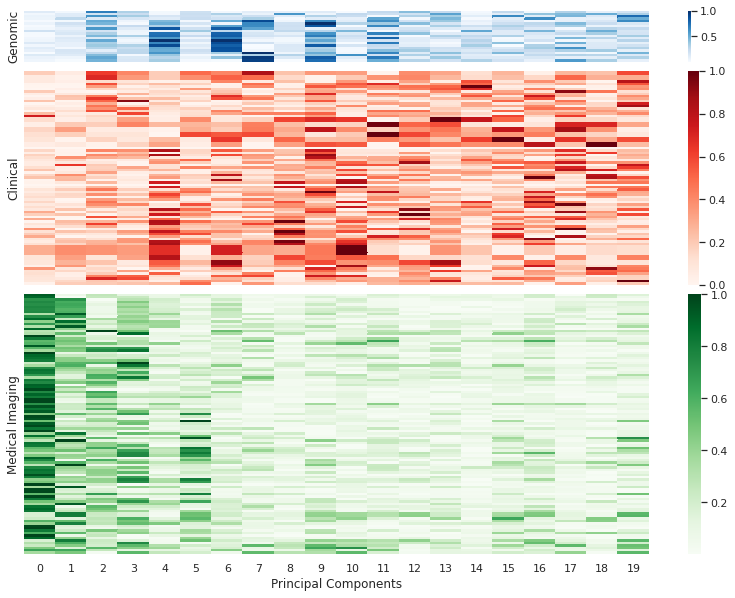

In [7]:
# Get column header for visualization
header = dataset.columns.values

sns.set(rc={'figure.figsize':(14,10)})

names = list(header)
names = names[1:]

# PCA and feature importance
# Indices depend on the above join operation on multiple tables  
indices = {'imaging': 108, 'clinical': 21}

# Set variance threshold for PCA to 99%
pca_threshold = 0.99
pca = PCA(n_components = pca_threshold)
X_trainval_pca = pca.fit_transform(X_trainval_scaled)
features_projected = abs(pca.components_).T
fn = MinMaxScaler().fit_transform(features_projected*pca.explained_variance_ratio_)

# Select top 20 PCs to plot
n_pc = 20
fn = fn[:,:n_pc]

fn_genomic = fn[0:indices['clinical'], :]
fn_clinical = fn[indices['clinical']:indices['imaging'], :]
fn_imaging = fn[indices['imaging']:, :]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, gridspec_kw={'wspace':0.025, 'hspace':0.052, 'height_ratios': [indices['clinical'], indices['imaging']-indices['clinical']+1, X.shape[1]-indices['imaging']]})

sns.heatmap(fn_genomic, ax=ax1, xticklabels=False, yticklabels=False, cmap="Blues", cbar=True)
sns.heatmap(fn_clinical, ax=ax2, xticklabels=False, yticklabels=False, cmap="Reds", cbar=True)
sns.heatmap(fn_imaging, ax=ax3, yticklabels=False, cmap="Greens", cbar=True)
ax3.set_xlabel('Principal Components')
ax3.set_ylabel('Medical Imaging')
ax2.set_ylabel('Clinical')
ax1.set_ylabel('Genomic')
plt.subplots_adjust(wspace=None, hspace=None)
plt.savefig('pca_matrix.png', dpi=450, bbox_inches='tight')

## Plot Correlation Circle 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


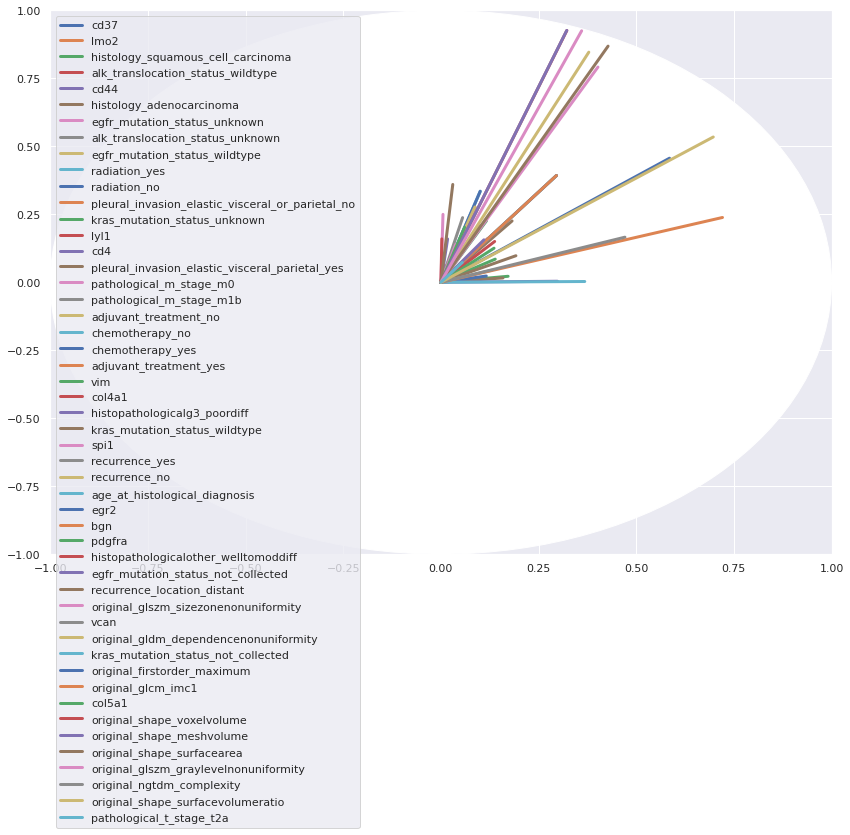

<Figure size 1008x720 with 0 Axes>

In [8]:
fig = plt.figure()
# Principal components to plot
pc_n1 = 4
pc_n2 = 5
r = np.linalg.norm(fn[:,pc_n1:pc_n2], axis=1)

ix_r = np.argsort(-r)
# Select top 30 features
top_r = 30
for i in range(top_r):
    plt.plot([0, fn[ix_r[i],0]], [0, fn[ix_r[i],1]], lw=3., label=names[ix_r[i]])

temp = np.max(r)
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((0, 0), radius=temp, edgecolor=None, facecolor='w')
ax.add_patch(circ)

plt.xlim([-temp, temp])
plt.ylim([-temp, temp])
plt.legend()
plt.show()
plt.savefig('correlationcircle.png', dpi=300, bbox_inches='tight')

## Run PCA for dimensioanality reduction

Number of principal components selected:  65


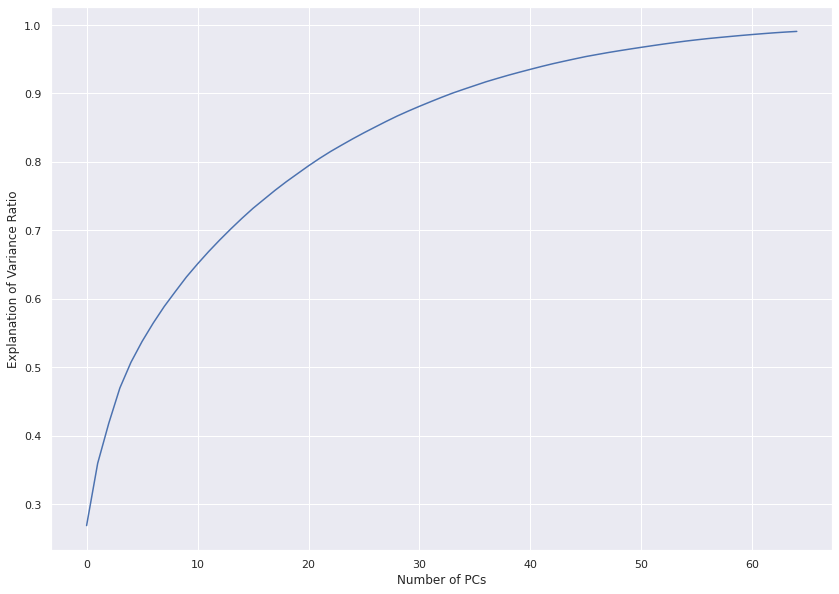

In [9]:
X_test_pca = pca.transform(X_test_scaled)
F = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(F)
plt.xlabel('Number of PCs')
plt.ylabel('Explanation of Variance Ratio')
print('Number of principal components selected: ', len(pca.explained_variance_ratio_))

## Split data for training and validation

In [10]:
# Split into training and validation data
X_train_pca, X_val_pca, y_train, y_val = train_test_split(X_trainval_pca, y_trainval, test_size=0.2, random_state=0)

print('Number of training samples: %d'%len(y_train))
print('Number of validation samples: %d'%len(y_val))

# Create training, validation, and test data by adding label as the first column and removing headers
X_train_pca = pd.DataFrame.from_records(X_train_pca)
train_data = pd.concat([y_train.reset_index(drop=True), X_train_pca.reset_index(drop=True)], axis=1)

X_val_pca = pd.DataFrame.from_records(X_val_pca)
validation_data = pd.concat([y_val.reset_index(drop=True), X_val_pca.reset_index(drop=True)], axis=1)

X_test_pca = pd.DataFrame.from_records(X_test_pca)
test_data = pd.concat([y_test.reset_index(drop=True), X_test_pca.reset_index(drop=True)], axis=1)

Number of training samples: 76
Number of validation samples: 19


## Train model

In [11]:
container = retrieve("xgboost", region=region, version='1.2-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sm_session)

xgb.set_hyperparameters(eta=0.1, objective='reg:logistic', num_round=10) 

# Save data
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

s3_input_train = TrainingInput(s3_data='s3://{}/{}/train/train.csv'.format(bucket, prefix), 
                               content_type='text/csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/validation.csv'.format(bucket, prefix), 
                                    content_type='text/csv')

# Train model
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-04-08 23:03:58 Starting - Starting the training job...
2021-04-08 23:04:21 Starting - Launching requested ML instancesProfilerReport-1617923038: InProgress
......
2021-04-08 23:05:22 Starting - Preparing the instances for training.........
2021-04-08 23:06:56 Downloading - Downloading input data
2021-04-08 23:06:56 Training - Downloading the training image.....[2021-04-08 23:07:42.447 ip-10-0-77-252.us-west-2.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input 

## Deploy model

In [12]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge', serializer = CSVSerializer())

---------------!

## Test model

In [13]:
def predict(data, rows=500):
    l_class = []
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = xgb_predictor.predict(array).decode('utf-8')
        
        l_prob = predictions.split(',')
    
        for prob in l_prob:
            if (float(prob) >0.5):
                l_class.append(1)
            else:
                l_class.append(0)
    
    return l_class

y_predict = predict(test_data.to_numpy()[:,1:])



acc = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict, average='weighted')
prec = precision_score(y_test, y_predict, average='weighted')
rec = recall_score(y_test, y_predict, average='weighted')

print('Accuracy: ', acc)
print('F1 score: ', f1)
print('Precision: ', prec)
print('Recall: ', rec)

Accuracy:  0.8333333333333334
F1 score:  0.8263305322128852
Precision:  0.8333333333333334
Recall:  0.8333333333333334
